# Evaluation of Models for Individual Identification

## 1. Initialization

In [0]:
#Set up Tensor flow 2.0

from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

In [0]:
#Import Libraries

#General

import cv2
import csv
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
from google.colab.patches import cv2_imshow
from collections import defaultdict
import random

import pickle

#sklearn ML libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.ensemble import IsolationForest
from sklearn.metrics.pairwise import cosine_similarity

#Keras/TF2.0 utilities
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense, Dropout
from tensorflow.keras.layers import Layer
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from keras.preprocessing import image as KImage


from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as VGG16Pre

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input as XceptionPre

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as MNPre

from tensorflow.keras.applications.imagenet_utils import preprocess_input


from tensorflow.keras.models import load_model


#Visualization/ Plots

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd



Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
#Mount Google Drive - Note this mounts your personal GDrive to the directory stated

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## 2. Load Test Data

In [0]:
#Set up various paths
#Set up path for csv files containing preprocessed images. CHange subfolder names to match your setup in google drive
csvpath='/content/drive/My Drive/U C Berkeley - Darragh/csv'
path="/content/drive/My Drive/U C Berkeley - Darragh/Training Data"
test_path="/content/drive/My Drive/U C Berkeley - Darragh/Test Data"
modelpath='/content/drive/My Drive/WildAI/csv/testing'


In [0]:
#Function to load processed image data in csv files (both training and test, input data labels)
def LoadData(train_imagefile="Training-Images-224.csv",train_labelfile="Training-Labels-224.txt",
               test_imagefile="Test-Images-224.csv",test_labelfile="Test-Labels-224.txt"):
  #Training Data Set
  Ind_DB=defaultdict(defaultdict)
  Individuals=[]
  Species=[]
  X=[]
  dataset=np.loadtxt(os.path.join(csvpath,train_imagefile),delimiter=",")
  f=open(os.path.join(csvpath,train_labelfile),'r')
  lines=f.readlines()
  for line in lines:
    vals=line.rstrip()
    Species.append(vals.split("-")[0])
    Individuals.append(vals)
  f.close()
    
  i=0
  print("populating Ind_DB")
  print("dataset size: ",len(dataset))
  for x in dataset:
    image=x.reshape(224,224,3)
    X.append(image)
    species=Species[i]
    key=Individuals[i]
    spec_DB=Ind_DB[species]
    if key not in spec_DB.keys():
      spec_DB[key]=[image]
    else:
      spec_DB[key].append(image)
    i=i+1

  print("Populating Test")
  #Test Data Set
  X_Test=[]
  Individuals_Test=[]
  Species_Test=[]
  dataset=np.loadtxt(os.path.join(csvpath,test_imagefile),delimiter=",")
  print("dataset size: ",len(dataset))
  for x in dataset:
    image=x.reshape(224,224,3)
    X_Test.append(image)
  
  f=open(os.path.join(csvpath,test_labelfile),'r')
  lines=f.readlines()
  for line in lines:
    vals=line.rstrip()
    Species_Test.append(vals.split("-")[0])
    Individuals_Test.append(vals)
  f.close()

  X_Test=np.asarray(X_Test)
    
  return (Ind_DB,X_Test,Species_Test,Individuals_Test)

In [0]:
# Load Pre-Processed Images

Ind_DB,X_Test,Species_Test,Individuals_Test=LoadData()



populating Ind_DB
dataset size:  1690
Populating Test
dataset size:  204


In [0]:
# Label encode species classes
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
le = LabelEncoder()
le.fit(Species_Test)
Y=le.transform(Species_Test)
print(le.classes_)



['African elephant' 'African lion' 'Amur Tiger' 'Bengal Tiger'
 'Black Rhino' 'Bongo' 'Cheetah' 'Leopard' 'Lowland Tapir' 'Puma'
 'White Rhino']


## 3. Individual Identification

### 3-1. Functions to Create searchable Reference list of "Footprint Embeddings" for each species/ Individual

In [0]:


# Encodes an image as a 'footprint embedding' using pretrained model
def Encode(X,trained_model):
  num=len(X)
  X_encoded=[]
  #print("Total = ",num)
  for i in range(num):
    x=np.asarray(X[i]).reshape(-1,224,224,3)
    #print(i,species,x.shape)
    model=trained_model
    X_encoded.append(model.predict(x))
  return X_encoded


#Given a set of footprints of a known individual, creates a single reference vector (or embedding)
# Uses either simple mean, mean without outliers , or isloation forests
def create_reference(input,type=0):
  if type==0:   #Simple Mean
    result=np.mean(input,axis=0)

  elif type==1:  #Remove outliers
    std=np.std(input,axis=0, dtype=np.float64)
    mean=np.mean(input,axis=0,dtype=np.float64)
    cutoff=std
    ll=mean-cutoff
    ul=mean+cutoff
    new_mean=np.zeros(input.shape[1])
    for j in range(input.shape[1]):
      keep=[]
      for i in range(input.shape[0]):
        if input[i,j]<ll[j] or input[i,j]>ul[j]:
          continue
        else:
          keep.append(input[i,j])
      new_mean[j]=np.mean(np.array(keep))
    result=new_mean
    
  elif type==2:  #Random Isolation Forests
    clf = IsolationForest( max_samples=10, random_state = 1, contamination= 'auto',verbose=0)
    preds = clf.fit_predict(input)
    new_mean=np.zeros(input.shape[1])
    for j in range(input.shape[1]):
      keep=[]
      for i in range(input.shape[0]):
        if preds[i]==1:
          keep.append(input[i,j])
      new_mean[j]=np.mean(np.array(keep))
    result=new_mean

  return result  


# For a given species returns a reference embedding (or footprint embedding )
# for each individual within that species

def FindReferenceEmbeddings(DB,trained_model):
  Ref_DB={}
  for individual,prints in DB.items():
    if 'Unknown' in individual:
      continue
    else:
      prints=np.asarray(prints)
      #print(individual, len(prints))
      prints_encoded=trained_model.predict(prints)
      #print(individual,"encoded")
      reference_print=create_reference(prints_encoded,type=0)
      Ref_DB[individual]=reference_print
  return Ref_DB


# Given a footprint for an unkown individual, finds closest individual within same species 
# Closest individual = individual with closest footprint embedding (using euclidean distance)
def findnearest(Ref_Individuals,X,type=0):
  inds=[]
  dist=[]
  for individual,embedding in Ref_Individuals.items():
    inds.append(individual)
    if type==0:  #L2 distance
      dist.append(np.linalg.norm(X - embedding))
    elif type==1:  #COsine simnilarity (only works if trained with cosine similarity for loss as well)
      cos=cosine_similarity(X.reshape(-1,1),embedding.reshape(-1,1))
      dist.append(cos[0][0])
  if type==0:
    i=np.argmin(np.asarray(dist))
  elif type==1:
    i=np.argmax(np.asarray(dist))
  found=inds[i]
  return found


### 3-2. Evaluation and Visualization functions

In [0]:
#creates TSNE plots for individuals within a species

def plotprints(df):
  dfx=df.drop(['Names'],axis=1)
  tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
  tsne_results = tsne.fit_transform(dfx)
  df['tsne-2d-one'] = tsne_results[:,0]
  df['tsne-2d-two'] = tsne_results[:,1]
  plt.figure(figsize=(16,10))
  num=df['Names'].nunique()

  sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                  hue="Names",
                  palette=sns.color_palette("hls", num),
                  data=df,
                  legend="full",
                  alpha=0.6)



In [0]:

tf.keras.backend.clear_session()
#Get base pre-trained model for species classification
def getBase(modelpath,savedmodel='species_classification_vgg16_model.h5'):
  zero_model = load_model(os.path.join(modelpath,savedmodel))
  x=zero_model.get_layer('Embedding').output
  x = Lambda(lambda  x: K.l2_normalize(x,axis=1))(x)
  triplet_model=Model(inputs=zero_model.input,outputs=x)
  input_shape=[224,224,3]
  X=Input(input_shape)
  encoded = triplet_model(X)
  return X,encoded


In [0]:
# Evaluate accuracy fo individual identification for given species given a set of test footprints for 
# unknown individuals within that species

def Species_Eval(species,spec_indx,Ind_DB,X_Test,Y,Individuals_Test,modelpath,
                 count,correct_count,correct,savedmodel='species_classification_vgg16_model.h5'):
  
  tf.keras.backend.clear_session()
  print("\n\nEVALUATING SPECIES: ",species)
  #Load Model
  inputs,outputs=getBase(modelpath,savedmodel)
  trained_model=Model(inputs=inputs,outputs=outputs)
  trained_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  fname='vgg16_best_model_'+str(species)+'.h5'
  trained_model.load_weights(os.path.join(modelpath,fname))

  #Create Reference Embeddings

  Ref_Embeddings[species]=FindReferenceEmbeddings(Ind_DB[species],trained_model) #STOP GAP

  #Evaluate Accuracy
  indices=[i for i in range(len(Y)) if Y[i] == spec_indx]
  X_T_encoded=Encode([X_Test[i] for i in indices],trained_model)
  Individuals_T=[Individuals_Test[i] for i in indices]
  num=len(X_T_encoded)

  print("\n----- Mismatches -------\n")
  for i in range(num):
    x=X_T_encoded[i]
    count[species]+=1
    true=Individuals_T[i]
    predicted=findnearest(Ref_Embeddings[species],x.reshape(1,-1),type=0)
    #predicted=predict(knns[species],pcas[species],x.reshape(1,-1))
    if true==predicted:
      correct=correct+1
      correct_count[species]+=1
    else:
      print(predicted,'  ----    ',true)
  print("\n----------------------\n")

  print("Accuracy for ",species,": ",correct_count[species]/num)

  #Visualize
  Animals=Ind_DB[species]
  Prints=[]
  Names=[]
  for individual,prints in Animals.items():
    Prints.extend(prints)
    Names.extend([individual]*len(prints))
  Prints=np.asarray(Prints)
  X_encoded=trained_model.predict(Prints)
  df=pd.DataFrame(X_encoded)
  df['Names']=Names
  plotprints(df)

  return (count,correct_count,correct)


## 4. Run Individual Identification on Test Data



EVALUATING SPECIES:  African elephant

----- Mismatches -------

African elephant-Sene   ----     African elephant-Thandi
African elephant-Paseka   ----     African elephant-Abu
African elephant-Mashudu   ----     African elephant-Abu

----------------------

Accuracy for  African elephant :  0.8695652173913043


EVALUATING SPECIES:  African lion

----- Mismatches -------

African lion-Elangeny   ----     African lion-Inca
African lion-Mogli   ----     African lion-Elsa
African lion-Bijan   ----     African lion-Mapivu
African lion-Bijan   ----     African lion-Mapivu

----------------------

Accuracy for  African lion :  0.8571428571428571


EVALUATING SPECIES:  Amur Tiger

----- Mismatches -------

Amur Tiger-682   ----     Amur Tiger-237
Amur Tiger-682   ----     Amur Tiger-261
Amur Tiger-440   ----     Amur Tiger-279
Amur Tiger-565   ----     Amur Tiger-440
Amur Tiger-682   ----     Amur Tiger-440
Amur Tiger-1020   ----     Amur Tiger-682

----------------------

Accuracy for  Am

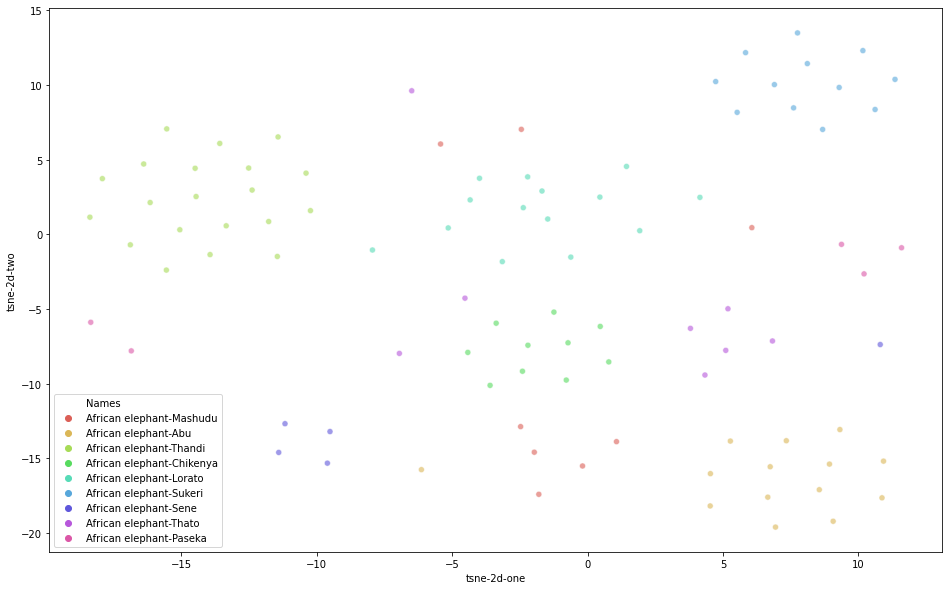

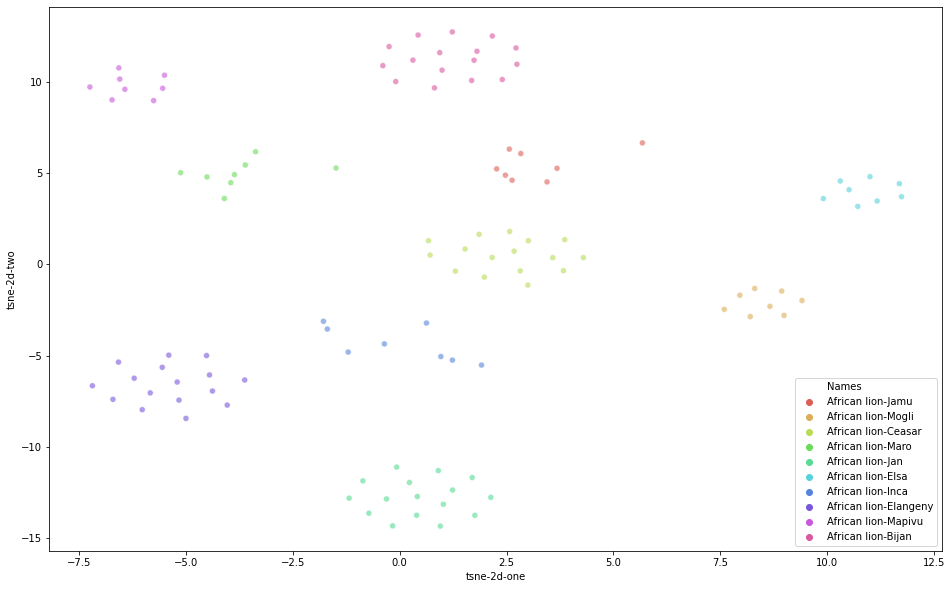

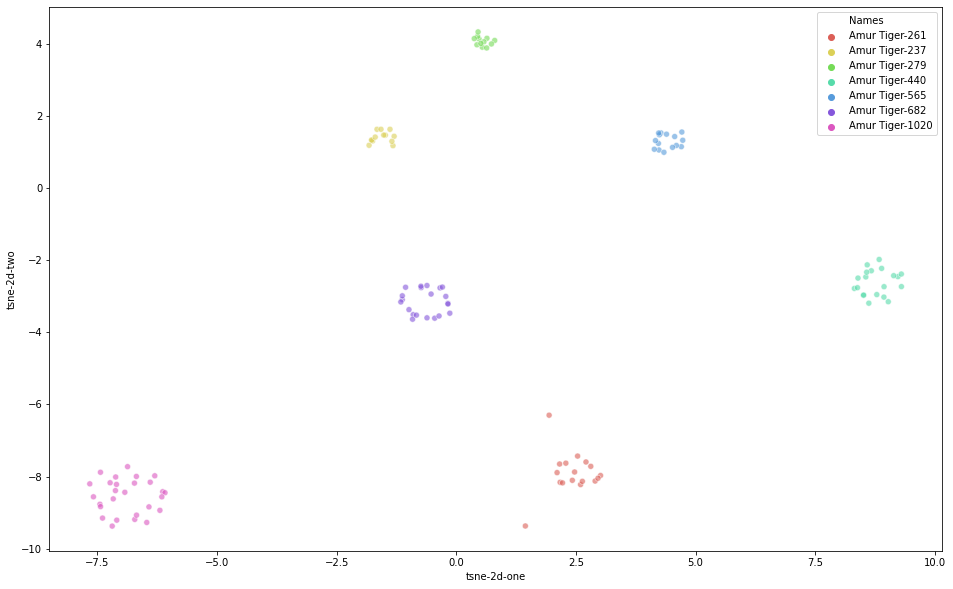

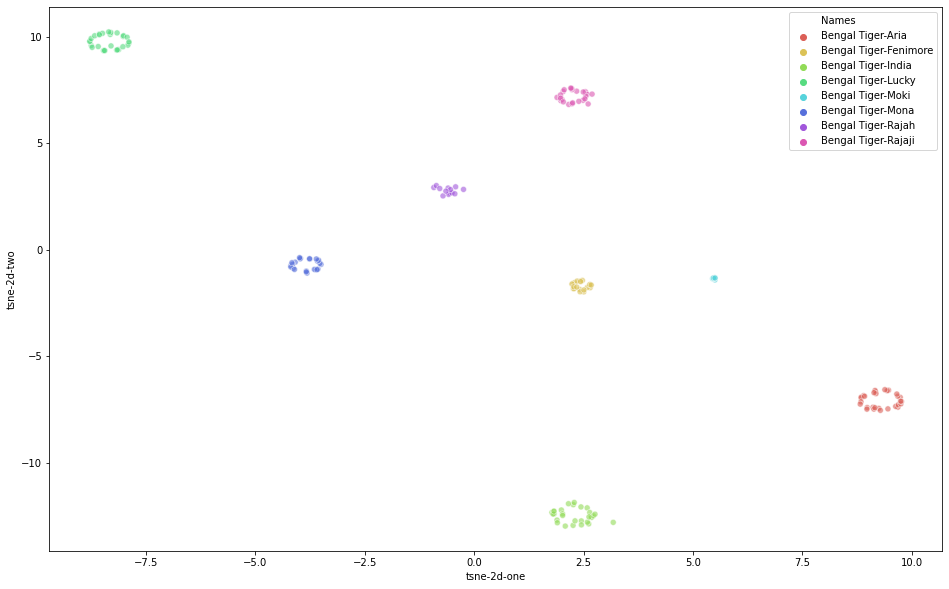

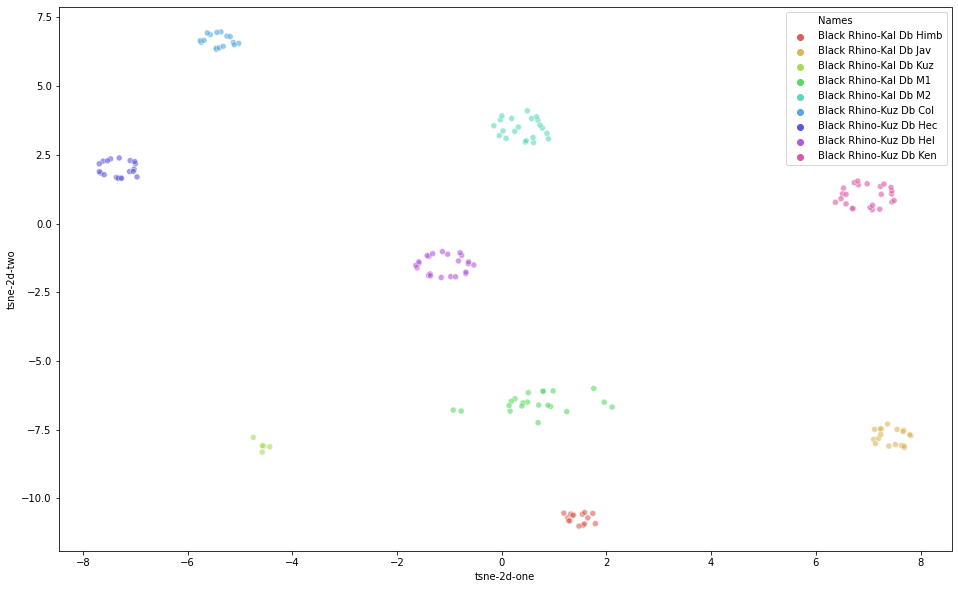

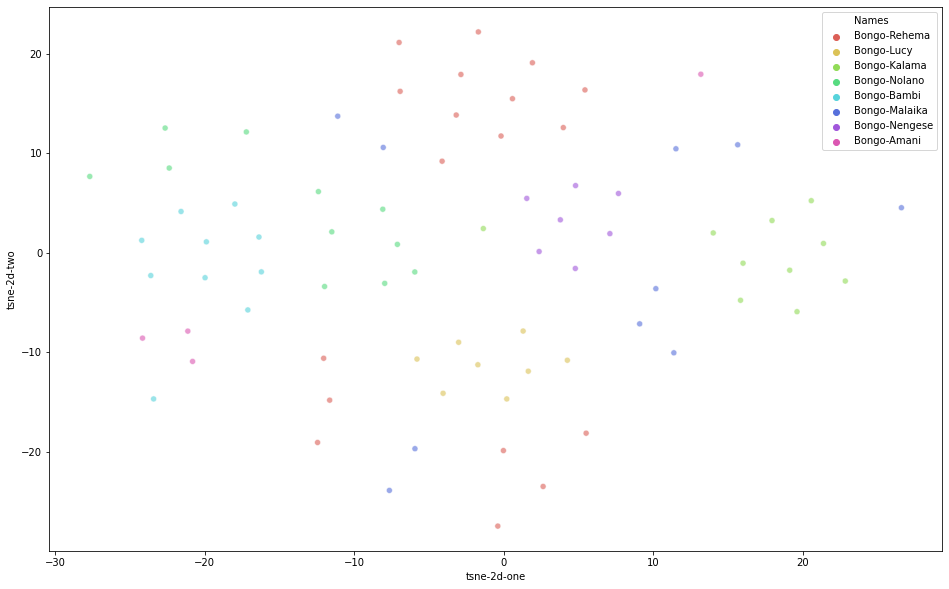

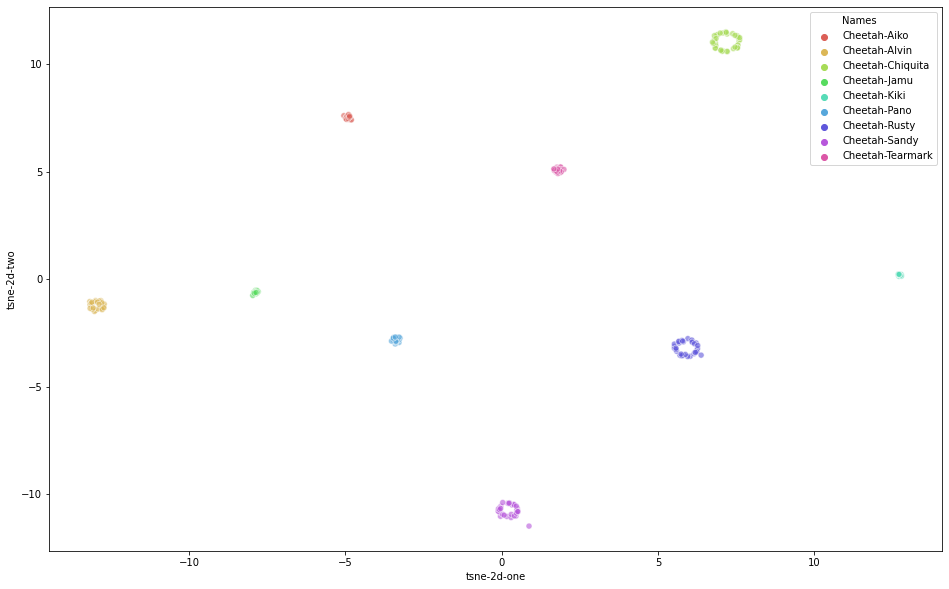

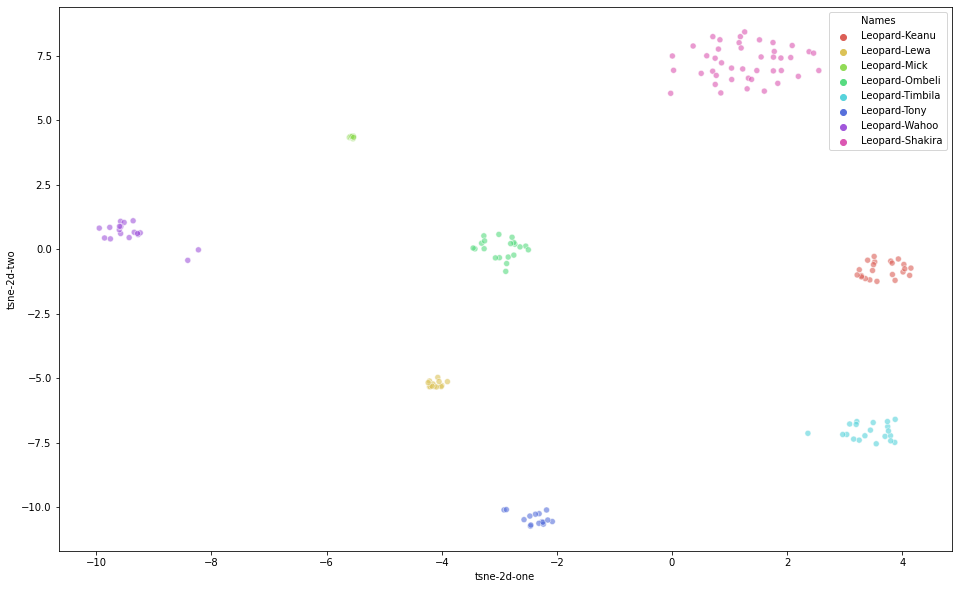

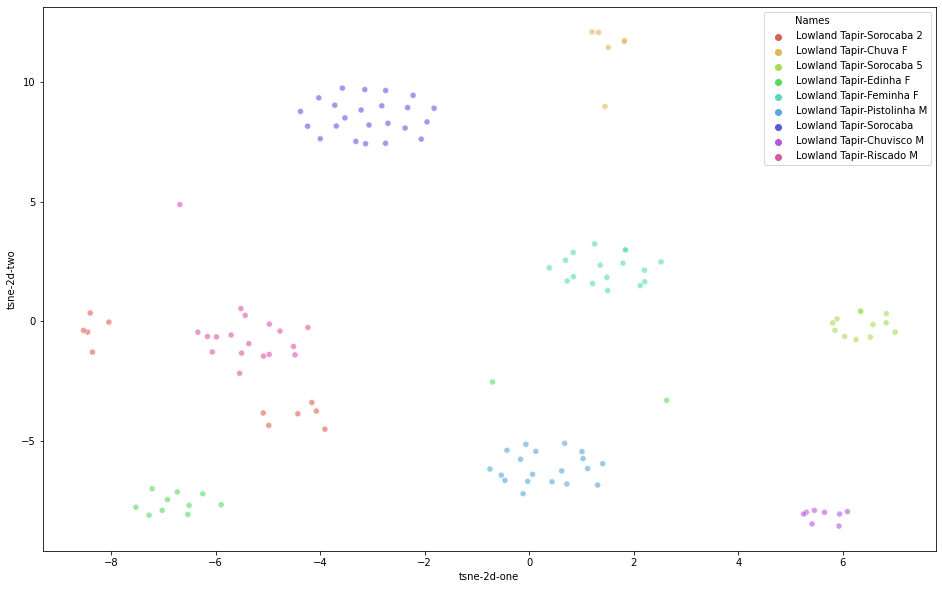

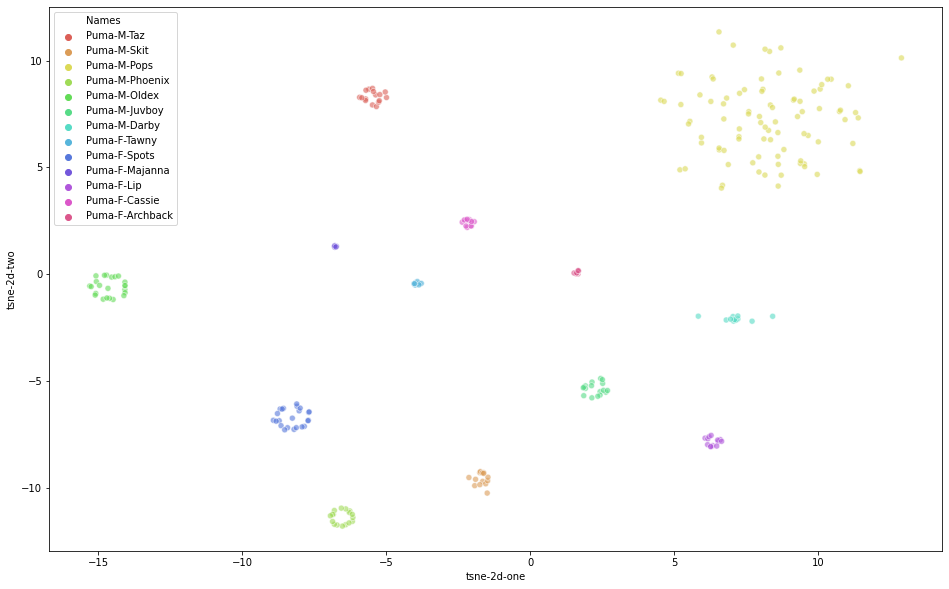

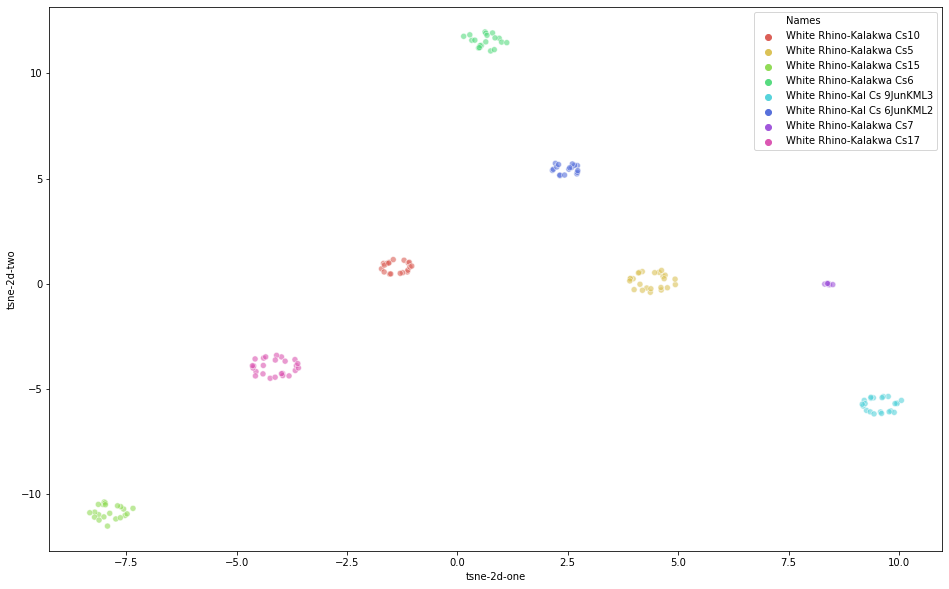

In [0]:
Ref_Embeddings={}
count=defaultdict(int)
correct_count=defaultdict(int)
correct=0
total=len(Y)

spec_indx=0
for species in le.classes_:
  count,correct_count,correct=Species_Eval(species,spec_indx,Ind_DB,X_Test,Y,Individuals_Test,modelpath,
                 count,correct_count,correct,savedmodel='species_classification_vgg16_model.h5')
  spec_indx=spec_indx+1
  

accuracy=correct/total
print("\n\nOVERALL ACCURACY: ",accuracy)

In [0]:
#Save all embeddings
#Save to disk for later retrieval
rp=open(os.path.join(csvpath,"individuals_reference.pickle"), "wb")
pickle.dump(Ref_Embeddings,rp,protocol=pickle.HIGHEST_PROTOCOL)
rp.close()